# Jenn Wong
jennwong@berkeley.edu

Data was gathered from Everlane Mode SQL database from running

select * from {database};

In [1]:
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

plt.style.use('ggplot')


import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/Users/jennwon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jennwon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jennwon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
users_df = pd.read_csv('users.csv')
orders_df = pd.read_csv('orders.csv')
products_df = pd.read_csv('products.csv')

In [3]:
users_df.discovery_time = pd.to_datetime(users_df.discovery_time)
users_df.head()

,user_id,discovery_channel_category,discovery_channel,discovery_time,discovery_platform,location,gender
0,1957598,paid,other,2017-05-10 07:23:23,desktop,US,female
1,1771115,paid,affiliate,2017-02-15 16:33:02,mobile,US,female
2,1489936,direct,NaN,2016-09-13 16:07:53,desktop,US,female
3,2356025,paid,search,2017-10-12 17:13:53,desktop,US,female
4,1463297,organic search,NaN,2016-08-17 07:06:25,desktop,international,female


In [4]:
orders_df.head()

# this is a string and should be date-time for easier analysis
orders_df.completed_at = pd.to_datetime(orders_df.completed_at) 
orders_df.head()

,line_item_id,order_id,completed_at,user_id,quantity,price,style_id,order_channel,order_channel_category
0,14134747,2874138,2016-12-29 14:54:22,1444626,1,25.0,447,other,paid
1,17240079,3506498,2017-09-05 19:00:51,1125825,1,68.0,944,search,paid
2,20017564,4020991,2017-12-27 17:41:00,2521400,1,88.0,890,search,paid
3,19281489,3858476,2017-12-01 18:53:11,2222476,1,62.0,640,other,paid
4,15018380,3047663,2017-03-26 15:38:13,1854949,1,100.0,650,affiliate,paid


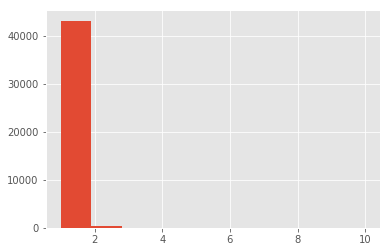

In [5]:
plt.hist(orders_df.quantity, bins = 10);

In [6]:
products_df.launch_date = pd.to_datetime(products_df.launch_date)
products_df.head()

,style_id,style,category,launch_date
0,592,The Premium Wool Flannel Pinstripe Track Pant,Bottoms,2016-09-19
1,572,The Luxe Drape Cropped Scoop-Neck Tee,Knit Tops,2016-07-26
2,645,The Cashmere Cardigan,Sweaters,2016-10-10
3,435,The Modern Flannel Shirt,Shirting,2016-02-25
4,874,The Pleated Midi Skirt,Bottoms,2017-08-24


## Question 1: New Product Launches

1. How would you measure the strength of a new product?
2. Based on this methodology, how would you summarise the recent trends of Everlane launch performance? Please support your answer with data.
3. What are the areas of opportunity when it comes to new launches?


I will be defining the 'strength' of the new product as number of sales in the first two weeks of launch (because I know that Everlane releases new products every week and constitutes a large part of its revenue). This will allow me to see how it performs as a 'new product' as well as an 'old-er product' and identify seasonal trends (if any) in the week.

In order to answer this question, I need to get metadata on the products that were ordered. I will be joining the orders_df with the products_df on 'style_id' in order to get the data that I need.

Recent 'trends' would be looking at the product and its metadata to evaluate if certain types of items are gaining popularity or something, or maybe something in the orders (discovery channel), or maybe it's the price bin 

In [7]:
detailed_orders = pd.merge(orders_df, products_df, how='left', on='style_id')
detailed_orders.head()

,line_item_id,order_id,completed_at,user_id,quantity,price,style_id,order_channel,order_channel_category,style,category,launch_date
0,14134747,2874138,2016-12-29 14:54:22,1444626,1,25.0,447,other,paid,The Pima Stretch Mid-Sleeve,Knit Tops,2016-01-26
1,17240079,3506498,2017-09-05 19:00:51,1125825,1,68.0,944,search,paid,The Cotton Turtleneck,Sweaters,2017-08-10
2,20017564,4020991,2017-12-27 17:41:00,2521400,1,88.0,890,search,paid,The Silk Long-Sleeve Blouse,Woven Tops,2017-09-14
3,19281489,3858476,2017-12-01 18:53:11,2222476,1,62.0,640,other,paid,The Ribbed Wool-Cashmere Sleeveless Turtleneck,Sweaters,2016-10-24
4,15018380,3047663,2017-03-26 15:38:13,1854949,1,100.0,650,affiliate,paid,The Cashmere Crew,Sweaters,2016-10-03


I could have done this in SQL too with the following query:

select * 
from recruiting.orders o
left join recruiting.products p on p.style_id = o.style_id;

In [8]:
time_period = 14 # this is the number of days after launch that I care about

detailed_orders['time_since_launch'] = (detailed_orders.completed_at - detailed_orders.launch_date)


# i only care about the days since launch and not such a high resolution
def get_days(date_time_object):
    """
    this function takes a datetime object and returns the days
    """
    return date_time_object.days

detailed_orders['days_since_launch'] = detailed_orders.time_since_launch.apply(get_days)

# I am creating a mask for orders made within the time period i'm interested in.
# sanity check, I know that all orders are at least 0 days since launch. there are some errors in the data though... 
recent_mask = (detailed_orders.days_since_launch <= time_period) & (detailed_orders.days_since_launch >0)

new_orders = detailed_orders[recent_mask]

print(f'I started with {len(detailed_orders)} number of orders. I now have {len(new_orders)} rows of recent orders')
# len(new_orders

new_orders.head()

I started with 43548 number of orders. I now have 4327 rows of recent orders


,line_item_id,order_id,completed_at,user_id,quantity,price,style_id,order_channel,order_channel_category,style,category,launch_date,time_since_launch,days_since_launch
9,12912030,2563686,2016-10-10 00:34:32,1333122,1,100.0,642,affiliate,paid,The Cashmere Crew,Sweaters,2016-10-03,7 days 00:34:32,7
29,14599945,2973712,2017-02-15 06:11:10,1769008,1,68.0,715,affiliate,paid,The Wide Leg Crop Pant,Bottoms,2017-02-14,1 days 06:11:10,1
37,14687198,2989227,2017-02-24 11:59:12,1732638,1,68.0,715,other,paid,The Wide Leg Crop Pant,Bottoms,2017-02-14,10 days 11:59:12,10
44,16116627,3290378,2017-06-18 05:40:10,656605,1,25.0,934,search,paid,Human Pride Unisex Tank in Double Print,Knit Tops,2017-06-05,13 days 05:40:10,13
48,18280552,3679979,2017-10-21 17:49:11,2380929,1,155.0,933,search,paid,The Waffle Knit Cashmere Square Crew,Sweaters,2017-10-12,9 days 17:49:11,9


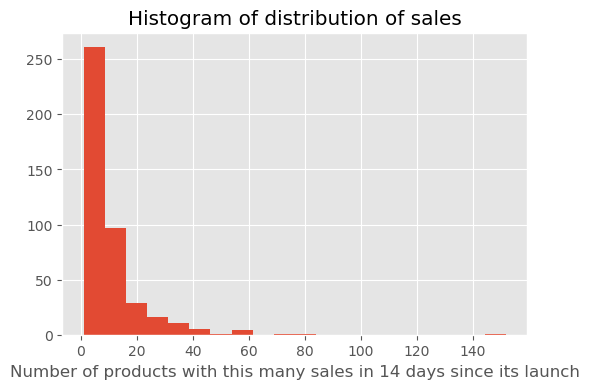

In [9]:
# so now I need to find the count of sales for each day over two weeks after launch for each product
sale_count = new_orders['style_id'].value_counts()
sale_count.rename(columns = {
    0: 'daily_order_count'
}, inplace = True)
sale_count.head()

plt.figure(dpi = 100)
plt.hist(sale_count, bins = 20)
plt.xlabel(f'Number of products with this many sales in {time_period} days since its launch')
plt.title('Histogram of distribution of sales')
plt.show();
# total_sales = sale_count.groupby('style_id').sum()['daily_order_count']
# total_sales = deepcopy(total_sales.sort_values(ascending = False)).reset_index()
# total_sales.rename(columns = {
#     'daily_order_count': 'total_order_count'
# }, inplace = True)
# total_sales.head()

# a way to visualize this would be to look at the top n performers and their sales and compare to bottom n


# I will take the top n products in terms of total number of sales in the time period and 


In [10]:
sale_count = pd.DataFrame(sale_count).reset_index()
sale_count.rename(columns = {
    'index': 'style_id',
    0: 'sale_count'
}, inplace = True)
sale_count.head()

,style_id,sale_count
0,908,152
1,887,80
2,909,73
3,888,61
4,642,57


This exponential decay of the distribution of product sales tells me there are 'strong' products which account for much of the sales within their the time frame specified since its launch. Next, I will be digging deeper to understand these 'strong' products better.

I think it would be interesting to see what is the most popular category over each month and binning prices to look at those over time as well


In [17]:
new_orders['price_bin'] = (new_orders.price//10) * 10
new_orders = pd.merge(new_orders, sale_count, how = 'left', on = 'style_id')
trends_df = new_orders[['style_id', 'category', 'launch_date', 'price_bin', 'sale_count']]
trends_df.drop_duplicates(inplace = True)

In [18]:
# defining top performing categories as how often they appear in the top 3rd of sales
top_n_categories = 7
trends_df.sort_values('sale_count', ascending = False, inplace = True)
top_categories = sorted(Counter(trends_df[:len(trends_df)//3]['category']).items(),
                        key = lambda x: x[1], reverse = True)

top_categories = [name for name, _ in top_categories[:top_n_categories]]

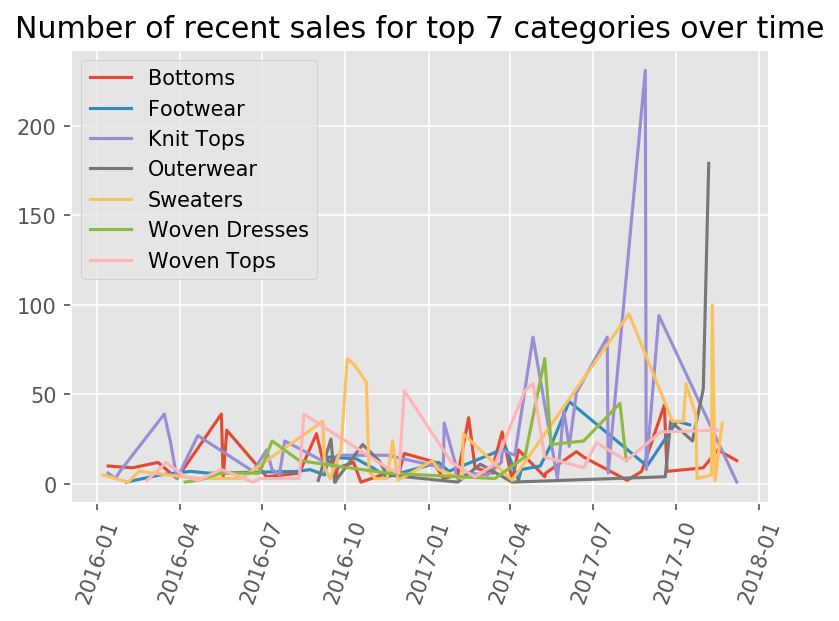

the complete list of categories: 
 ['Shirting', 'Knit Tops', 'Woven Tops', 'Seasonal Accessories', 'Sweaters', 'Other', 'Knit Dresses', 'Outerwear', 'Footwear', 'Denim', 'Bottoms', 'SLGs', 'Woven Dresses', 'Bags']


In [30]:
# group by the category and sum the sale_counts and graph over time
plt.figure(dpi = 150)
legend_labels = []

for name, group in trends_df.groupby(['category']):
    if name in top_categories:
        legend_labels.append(name)
        category_df = group.groupby('launch_date')['sale_count'].sum().reset_index()
        plt.plot(category_df.launch_date, category_df.sale_count)
#         break
plt.title(f'Number of recent sales for top {len(top_categories)} categories over time')
plt.legend(legend_labels)
plt.xticks(rotation = 70)
plt.show();

print(f'the complete list of categories: \n {list(set(new_orders.category))}')

But the question still remains...what trends was I able to identify??????

Comparing the list of categories that emerged as consistently 'strong' products to all of the different categories, we see that most of the 'strong' products are most appropriate for winter/colder climates. from my intuition, and experience, I know that Winter clothes are valued for their quality. Perhaps this is a proxy for how much customers likes Everlane [Winter] products as they are consistently the top performers.

Some areas of opportunity regarding launching new products:
1. Collecting more data to validate or refute claim that winter products are more valued because of quality
2. Are most of the customers driving the revenue repeat customers or new customers
3. How did they get to the site? What facilitated them to browse products and ultimately check out?

In [29]:
# i'm intersted in exploring the price_bins

# trends_df.groupby('price_bin').sum()

# for name, group in trends_df.groupby(['price_bin']):
# #     if name in top_categories: 
# #         legend_labels.append(name)
# #         print(name)
#         category_df = group.groupby('launch_date')['sale_count'].sum().reset_index()
#         plt.plot(category_df.launch_date, category_df.sale_count)
#         break
# # plt.title(f'Number of recent sales for top {len(top_categories)} categories over time')
# # plt.legend(legend_labels)
# plt.xticks(rotation = 70)
# plt.show();

I wonder if the weekday of when products are launched will affect sales

In [31]:
# plt.plot(total_sales.launch_date, total_sales.total_order_count, '.');

# i think it would be nice to plot a regression line to see the slope if it's trending upwards

To identify trends, I am looking for categories that show up the most frequently in the top 3rd of sales of their 14 day launch period.

In [ ]:
# popular_n_categories = 7
# popular_items = total_sales[:len(total_sales)//3] # to get the most popular 3rd

# popular_items_counter = Counter(popular_items.category)
# popular_items_counter = sorted(popular_items_counter.items(), key=lambda x: x[1], reverse = True)
# popular_items_counter

# popular_categories = ([category for category, _ in popular_items_counter[:popular_n_categories]])

In [ ]:
# plt.figure(dpi = 100)

# for name, grp in (total_sales.groupby(['category'])):
#     if name in popular_categories:
# #     if name == 'Knit Tops':
#         plt.plot(grp['launch_date'], grp['total_order_count'], '.', label=name)

# plt.title(f'Total Sales within {time_period} days of launch of top {popular_n_categories} categories')    
# plt.legend();

If I had more time, I would try to model this information by figuring out which features will make a product a 'success' as defined by having higher than average total sales. i think it would also be interesting to look at the projections for a product and compare it to how well it actually did

#### Additionally, I know that new users drive revenue for Everlane as well. 
Therefore I think it's important to see how new_products fair for this segment of the market, and possibly compare it to not-new users as well. If there is a strong sales trend in non-new users, that could be an indicator of the 'strength' of the new product!

## Question 2: New Customer Acquisition

1. How would you measure the 'strength' of new customer acquisition?
2. Based on this measurement, what would you say are the most valuable channels?
3. What additional data would you like to look at to measure acqusition performance?